<a href="https://colab.research.google.com/github/opopiol/ML_project/blob/model/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm
from imblearn.over_sampling import SMOTE

### **Neptune**

In [3]:
%pip install --upgrade --quiet neptune-client
#pip install neptune-notebooks

     |████████████████████████████████| 245kB 5.2MB/s 
     |████████████████████████████████| 829kB 10.1MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
     |████████████████████████████████| 174kB 18.8MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 133kB 18.2MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 


In [4]:
import neptune.new as neptune
#run = neptune.init(project='opopiol/ML-project')
run = neptune.init(project='opopiol/ML-project',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI5YjIyYjU2ZS0wMTc5LTQ3NWUtOWZkZC05OTg2YzI1M2VkNDUifQ==') # your credentials

run["JIRA"] = "NPT-952"
run["parameters"] = {"learning_rate": 0.001,
                     "optimizer": "Adam"}

for epoch in range(100):
   run["train/loss"].log(epoch * 0.4)
run["eval/f1_score"] = 0.66

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/opopiol/ML-project/e/MLPROJ-9
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


###**Reducing DataFrame memory size**


In [5]:
#Reducing DataFrame memory size
#https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65?fbclid=IwAR3XPzjakD69RqAEKuAnTDUtfw3AeCAj19eyd6LfzVSwHHICNgxW-ptK-vs

def reduce_mem_usage(props):
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            #print("******************************")
            #print("Column: ",col)
            #print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            #print("dtype after: ",props[col].dtype)
            #print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props

### **Data import**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#import train dataset
train_path = '/content/drive/MyDrive/project/train_data.csv'
train_data = pd.read_csv(train_path, header=None)

In [8]:
train_data= reduce_mem_usage(train_data)

Memory usage of properties dataframe is : 286.1024169921875  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  143.05126953125  MB
This is  50.000021333324234 % of the initial size


In [9]:
#import labels
labels_path = '/content/drive/MyDrive/project/train_labels.csv'
labels = pd.read_csv(labels_path, header=None,  names=['y'])

In [10]:
labels= reduce_mem_usage(labels)

Memory usage of properties dataframe is : 0.0287322998046875  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  0.0036983489990234375  MB
This is  12.871747211895912 % of the initial size


In [11]:
#import test dataset
test_path = '/content/drive/MyDrive/project/test_data.csv'
test_data = pd.read_csv(test_path, header=None)

In [12]:
test_data= reduce_mem_usage(test_data)

Memory usage of properties dataframe is : 95.3675537109375  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  47.67668533325195  MB
This is  49.99256400951807 % of the initial size


In [31]:
X, y = train_data, labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y)

### **MODEL**

In [85]:
def get_confusion_matrix(classifier):
    """This function returns a confusion matrix of given classifier
    :param classifier: classifier
    :return: print(confusion_matrix(y_test, y_pred)): confusion matrix of given classifier
    """
    m = classifier.fit(X, y)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    print(confusion_matrix(y_test, y_pred))

### **Baseline**

For stratified strategy f1 score is 0.9054187192118227 with labels: [-1  1]
[[  9 103]
 [ 92 921]]
For most_frequent strategy f1 score is 0.9476145930776426 with labels: [1]
[[   0  112]
 [   0 1013]]
For prior strategy f1 score is 0.9476145930776426 with labels: [1]
[[   0  112]
 [   0 1013]]
For uniform strategy f1 score is 0.6213093709884469 with labels: [-1  1]
[[ 60  52]
 [527 486]]


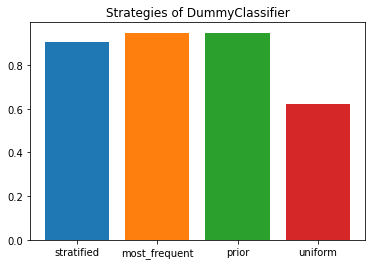

In [90]:
#baseline
strategies = ['stratified', 'most_frequent', 'prior', 'uniform']

def dummy_base(list):
  """This function returns scores and plot with scores of the given strategies of DummyClassifier
    :param list: list of strategies
    :return: print(f'For {i} strategy score is {dummy_clf_score} with labels: {dummy_labels}'): scores of the strategies given in the list and labels
    :return: plt.bar(i, dummy_clf_score): plot with scores of the strategies given in the list
    :return: get_confusion_matrix(dummy_clf): function returning a confusion matrix
    """
  for i in list:
      dummy_clf = DummyClassifier(strategy=i)
      dummy_clf.fit(X_train, y_train)
      y_pred = dummy_clf.predict(X_test)
      dummy_clf_score = f1_score(y_test, y_pred)
      dummy_labels = np.unique(dummy_clf.predict(X_test))
      print(f'For {i} strategy f1 score is {dummy_clf_score} with labels: {dummy_labels}')
      get_confusion_matrix(dummy_clf)
      
      plt.title('Strategies of DummyClassifier')
      plt.bar(i, dummy_clf_score)
            
dummy_base(strategies)



In [89]:
def base_decisiontree_clf():
    """This function returns score of DecisionTreeClassifier
    :return: print(dtc_clf.__class__.__name__, dtc_clf_score): score of the classifier
    :return: get_confusion_matrix(dtc_clf): function returning a confusion matrix
    """
    dtc_clf = DecisionTreeClassifier().fit(X, y)
    dtc_clf.fit(X_train, y_train)
    y_pred = dtc_clf.predict(X_test)
    dtc_clf_score = f1_score(y_test, y_pred)
    print(dtc_clf.__class__.__name__, dtc_clf_score)
    get_confusion_matrix(dtc_clf)

base_decisiontree_clf()

DecisionTreeClassifier 0.9629995066600889
[[ 74  38]
 [ 37 976]]
[[ 72  40]
 [ 27 986]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression 0.8907815631262526


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 18  94]
 [124 889]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app


KNeighborsClassifier 0.976926853215513


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


[[ 83  29]
 [ 18 995]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC 0.9782393669634025


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 92  20]
 [ 24 989]]


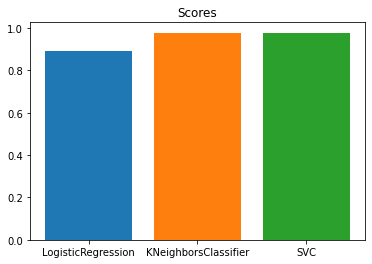

In [57]:
log_clf = LogisticRegression(random_state=0, max_iter = 1000)
knn_clf = KNeighborsClassifier()
svm_clf = SVC()
#voting_clf = VotingClassifier()

clf_list = [log_clf, knn_clf, svm_clf]

def clf_scores(list):
  """This function returns scores and plot with scores of the classifiers given in the list
    :param list: list of classifiers
    :return: print(clf.__class__.__name__, accuracy_score(y_test, y_pred)): scores of the classifiers given in the list
    :return: plt.bar(clf.__class__.__name__, accuracy_score(y_test, y_pred)): plot with scores of the classifiers given in the list
    :return: get_confusion_matrix(clf): function returning a confusion matrix
    """
  for clf in list:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    clf_score = f1_score(y_test, y_pred)
    print(clf.__class__.__name__, clf_score)
    get_confusion_matrix(clf)


    plt.title('Scores')
    plt.bar(clf.__class__.__name__, clf_score);

clf_scores(clf_list)


### **AdaBoostClassifier**

In [103]:
from sklearn.ensemble import AdaBoostClassifier

estimator = AdaBoostClassifier()

def get_parameters(clf):
  print(clf.get_params().keys())

get_parameters(estimator)

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])


In [104]:
def base_adaboost_clf():
    """This function returns score of AdaBoostClassifier
    :return: print(ab_clf_clf.__class__.__name__, ab_clf_score): score of the classifier
    :return: get_confusion_matrix(ab_clf): function returning a confusion matrix
    """
    ab_clf = AdaBoostClassifier()
    ab_clf.fit(X_train, y_train.values)
    y_pred = ab_clf.predict(X_test)
    ab_clf_score = f1_score(y_test, y_pred)
    print(ab_clf.__class__.__name__, ab_clf_score)
    get_confusion_matrix(ab_clf)

base_adaboost_clf()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier 0.9654164637116415


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 63  49]
 [ 22 991]]


In [105]:
def pipeline_ab_clf(x_1: np.array, x_2: np.array, y_1: np.array, y_2: np.array):
    """This function returns best model from given paramerters
    :param: x_1: np.array: train data after splitting
    :param: x_2: np.array: test data after splitting
    :param: y_1: np.array: train of values after splitting
    :param: y_2: np.array: test of values after splitting

    :return: print(best_model.best_estimator_): returns best model out of given
    :return: print("The score of the model is:",f1_score(y_test, y_pred)): returns f1_score from choosen best model
    :return: print(confusion_matrix(y_test, y_pred)): returns confusion_matrix
    """
    classifier = AdaBoostClassifier()
    param = [{'n_estimators': [50, 100, 150],
            'learning_rate': [0.1, 0.01, 0.05]}]

    grid_search = GridSearchCV(classifier,
                              param,
                              cv=3,
                              verbose=2,
                              n_jobs=-1,
                              scoring='f1')

    
    best_model = grid_search.fit(x_2, y_2.values)
    print(best_model.best_estimator_)
    y_pred = best_model.predict(x_2)
    print("The score of the model is:",f1_score(y_2, y_pred))
    print(confusion_matrix(y_2, y_pred))


pipeline_ab_clf(X_train, X_test, y_train, y_test)


Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 28.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=50, random_state=None)
The score of the model is: 0.983267716535433
[[ 92  20]
 [ 14 999]]


### **Final model**

In [102]:
#creating final pipeline

def pipeline_final_model(x_1: np.array, x_2: np.array, y_1: np.array, y_2: np.array):
    """This function returns best model from given paramerters
    :param: x_1: np.array: train data after splitting
    :param: x_2: np.array: test data after splitting
    :param: y_1: np.array: train of values after splitting
    :param: y_2: np.array: test of values after splitting

    :return: print(best_model.best_estimator_): returns best model out of given
    :return: print("The score of the model is:",f1_score(y_test, y_pred)): returns f1_score from choosen best model
    :return: print(confusion_matrix(y_test, y_pred)): returns confusion_matrix
    """
    pipe = Pipeline([('pca', PCA(n_components = 0.99)), ('scaler', StandardScaler()), ('classifier', SVC())])

    search_space = [{'scaler': [StandardScaler()],
                    'pca': [PCA(n_components = 0.99)]},
                    {'classifier': [SVC()],
                    'classifier__kernel': ['linear', 'poly'],
                    'classifier__class_weight': ['balanced'],
                    'classifier__C': np.logspace(1,4,5)},
                    {'classifier': [KNeighborsClassifier()],
                    'classifier__n_neighbors': [2, 4, 6, 8, 10],
                    'classifier__algorithm': ['auto']},
                    {'classifier': [AdaBoostClassifier()],
                    'classifier__n_estimators': [50],
                    'classifier__learning_rate': [0.1]}]

    grid_search = GridSearchCV(pipe,
                              search_space,
                              cv=3,
                              verbose=2,
                              n_jobs=-1,
                              scoring='f1')
    
    best_model = grid_search.fit(x_2, y_2.values)
    print(best_model.best_estimator_)
    y_pred = best_model.predict(x_2)
    print("The score of the model is:",f1_score(y_2, y_pred))
    print(confusion_matrix(y_2, y_pred))


pipeline_final_model(X_train, X_test, y_train, y_test)

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  2.2min finished
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.99,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
                                    learning_rate=0.1, n_estimators=50,
                                    random_state=None))],
         verbose=False)
The score of the model is: 0.982213438735178
[[ 95  17]
 [ 19 994]]


In [56]:
#sns.swarmplot(data=X_train, y='clf', x='score')

In [ ]:
https://blog.prokulski.science/2020/12/23/hyperopt-scikit-learn/

Pewnie nie muszę przypominać, że podczas poszukiwania parametrów, oceny klasyfikatora powinniśmy dokonywać na danych, które nie były wykorzystywane do treningu. W przeciwnym wypadku padamy ofiarą przeuczenia (ang. overfittingu), czyli dostosowania się algorytmu do naszego zbioru. Obliczony model będzie działał rewelacyjnie na danych treningowych, ale już na rzeczywistych będziemy osiągali słabe wyniki. Najłatwiej można poradzić sobie na dwa sposoby:

    Podzielić zbiór treningowy na dwie części, służącą do treningu (train dataset) oraz walidacyjną (validation dataset). Poszukiwanie parametrów uruchamiać na części treningowej a ocenę przeprowadzić na części walidacyjnej.